## Pilot 3B

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_theme(style="darkgrid")

from dotenv import load_dotenv
import os
import glob
import json

In [2]:
# directory management
pilot_name = "rn-iii-pilot-3"
to_save_plots = True
data_path = f"../../data/for_plots/{pilot_name}"

figures_path = f"../figures/{pilot_name}"
if not os.path.exists(figures_path):
    os.makedirs(figures_path)

scores_df = pd.read_csv(os.path.join(data_path,"scores.csv"),index_col=0)
trials_time = pd.read_csv(os.path.join(data_path,"trials_time.csv"))
sessions_time = pd.read_csv(os.path.join(data_path,"sessions_time.csv"))
post_survey_df = pd.read_csv(os.path.join(data_path,"post_survey_df.csv"))

## post survey plots

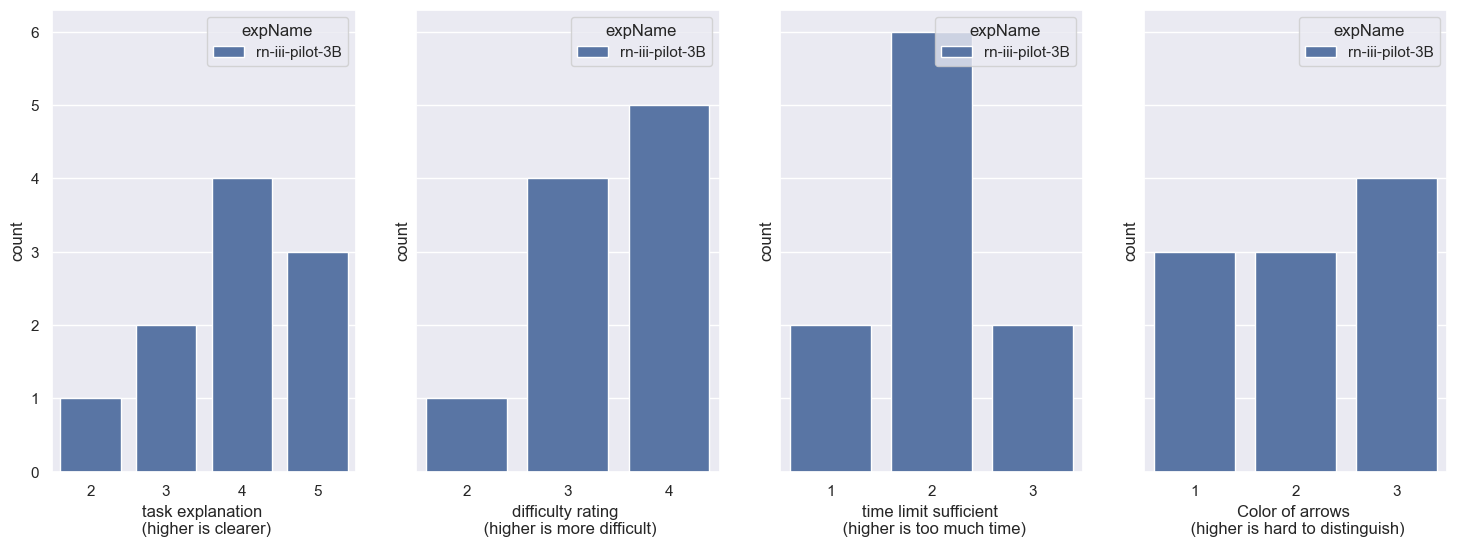

In [133]:
variables = ['task_explanation', 'difficulty_rating', 'time_limit_sufficient', 'arrows_color']
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, len(variables), sharey=True, figsize=(18, 6))

sns.countplot(data=post_survey_df, x="task_explanation", hue="expName", ax=ax1)
ax1.set_xlabel('task explanation \n (higher is clearer)')
sns.countplot(data=post_survey_df, x="difficulty_rating", hue="expName", ax=ax2)
ax2.set_xlabel('difficulty rating \n (higher is more difficult)')
sns.countplot(data=post_survey_df, x="time_limit_sufficient", hue="expName", ax=ax3)
ax3.set_xlabel('time limit sufficient \n (higher is too much time)')
sns.countplot(data=post_survey_df, x="arrows_color", hue="expName", ax=ax4)
ax4.set_xlabel('Color of arrows \n (higher is hard to distinguish)')

if to_save_plots:
    f.savefig(os.path.join(figures_path, 'post_survey.pdf'), format='pdf', dpi=300)
    f.savefig(os.path.join(figures_path, 'post_survey.png'), format='png', dpi=300)

## Scores plots
### preprocessing

In [134]:
#scores_df['trialIdx'] = scores_df['trialIdx'].astype('int')
scores_df.replace({"isAI": {True: 'AI', False: 'Human'}}, inplace=True)
scores_df.groupby(by=["expName","trialType","isAI"]).size()

expName          trialType      isAI 
rn-iii-pilot-3B  demonstration  AI       20
                                Human    20
                 individual     AI       40
                                Human    60
                 try_yourself   AI       10
                                Human    80
dtype: int64

## decode the before and after individual and try_yourself trials

In [135]:
scores_df

,sessionId,isAI,expName,generation,trialIdx,trialType,networkId,score,maxLevelReached,myopic_score,ai_score
0,6422d978aff8868105633828,AI,rn-iii-pilot-3B,0,NaN,try_yourself,NaN,NaN,NaN,NaN,NaN
1,6422d978aff8868105633828,AI,rn-iii-pilot-3B,0,0.0,individual,ee03606912fff2d5496ca438ddf0e182,1050.0,4.0,600.0,1050.0
2,6422d978aff8868105633828,AI,rn-iii-pilot-3B,0,1.0,individual,b06e63e23be6e795171cc39de5f68b04,1050.0,4.0,1200.0,1050.0
3,6422d978aff8868105633828,AI,rn-iii-pilot-3B,0,2.0,individual,cb226a27079683c5a81e7c73450fd1d7,850.0,4.0,800.0,850.0
4,6422d978aff8868105633828,AI,rn-iii-pilot-3B,0,3.0,individual,bbd3fb74933edbeb8aee7fb3ead010ec,1250.0,4.0,800.0,1250.0
...,...,...,...,...,...,...,...,...,...,...,...
225,6422d978aff886810563383c,Human,rn-iii-pilot-3B,1,25.0,individual,a2c663a5e2c6b59d546691602456bfce,100.0,2.0,0.0,1250.0
226,6422d978aff886810563383c,Human,rn-iii-pilot-3B,1,26.0,individual,35f070abfb64c2499229d1ee32cf54b6,1050.0,1.0,1100.0,1450.0
227,6422d978aff886810563383c,Human,rn-iii-pilot-3B,1,27.0,individual,8873dfa1b3059e8c7bbb2a75f76b3b83,350.0,1.0,350.0,1250.0
228,6422d978aff886810563383c,Human,rn-iii-pilot-3B,1,29.0,demonstration,59bc73ae47a896adda8a3eeec20e03fb,1000.0,2.0,650.0,850.0


In [136]:
scores_df_ai = scores_df[scores_df['isAI']=='AI']
scores_df_human = scores_df[scores_df['isAI']=='Human']

scores_df_human.loc[scores_df_human['trialIdx'].isin([10,13,17,20]), 'trialType'] = 'try_yourself_before'
scores_df_human.loc[scores_df_human['trialIdx'].isin([12,15,19,22]), 'trialType'] = 'try_yourself_after'
scores_df_human.loc[scores_df_human['trialIdx'].isin([4,5]), 'trialType'] = 'individual_before'
scores_df_human.loc[scores_df_human['trialIdx'].isin([24,25,26,27]), 'trialType'] = 'individual_after'

scores_df = pd.concat([scores_df_ai, scores_df_human])

In [137]:
scores_df.groupby(by=["expName","trialType","isAI"]).size()

expName          trialType            isAI 
rn-iii-pilot-3B  demonstration        AI       20
                                      Human    20
                 individual           AI       40
                 individual_after     Human    40
                 individual_before    Human    20
                 try_yourself         AI       10
                 try_yourself_after   Human    40
                 try_yourself_before  Human    40
dtype: int64

In [138]:
# create plot hue
scores_df['plot_hue'] = scores_df['isAI'].astype(str) + ', ' + scores_df['trialType'].astype(str)
scores_df

,sessionId,isAI,expName,generation,trialIdx,trialType,networkId,score,maxLevelReached,myopic_score,ai_score,plot_hue
0,6422d978aff8868105633828,AI,rn-iii-pilot-3B,0,NaN,try_yourself,NaN,NaN,NaN,NaN,NaN,"AI, try_yourself"
1,6422d978aff8868105633828,AI,rn-iii-pilot-3B,0,0.0,individual,ee03606912fff2d5496ca438ddf0e182,1050.0,4.0,600.0,1050.0,"AI, individual"
2,6422d978aff8868105633828,AI,rn-iii-pilot-3B,0,1.0,individual,b06e63e23be6e795171cc39de5f68b04,1050.0,4.0,1200.0,1050.0,"AI, individual"
3,6422d978aff8868105633828,AI,rn-iii-pilot-3B,0,2.0,individual,cb226a27079683c5a81e7c73450fd1d7,850.0,4.0,800.0,850.0,"AI, individual"
4,6422d978aff8868105633828,AI,rn-iii-pilot-3B,0,3.0,individual,bbd3fb74933edbeb8aee7fb3ead010ec,1250.0,4.0,800.0,1250.0,"AI, individual"
...,...,...,...,...,...,...,...,...,...,...,...,...
225,6422d978aff886810563383c,Human,rn-iii-pilot-3B,1,25.0,individual_after,a2c663a5e2c6b59d546691602456bfce,100.0,2.0,0.0,1250.0,"Human, individual_after"
226,6422d978aff886810563383c,Human,rn-iii-pilot-3B,1,26.0,individual_after,35f070abfb64c2499229d1ee32cf54b6,1050.0,1.0,1100.0,1450.0,"Human, individual_after"
227,6422d978aff886810563383c,Human,rn-iii-pilot-3B,1,27.0,individual_after,8873dfa1b3059e8c7bbb2a75f76b3b83,350.0,1.0,350.0,1250.0,"Human, individual_after"
228,6422d978aff886810563383c,Human,rn-iii-pilot-3B,1,29.0,demonstration,59bc73ae47a896adda8a3eeec20e03fb,1000.0,2.0,650.0,850.0,"Human, demonstration"


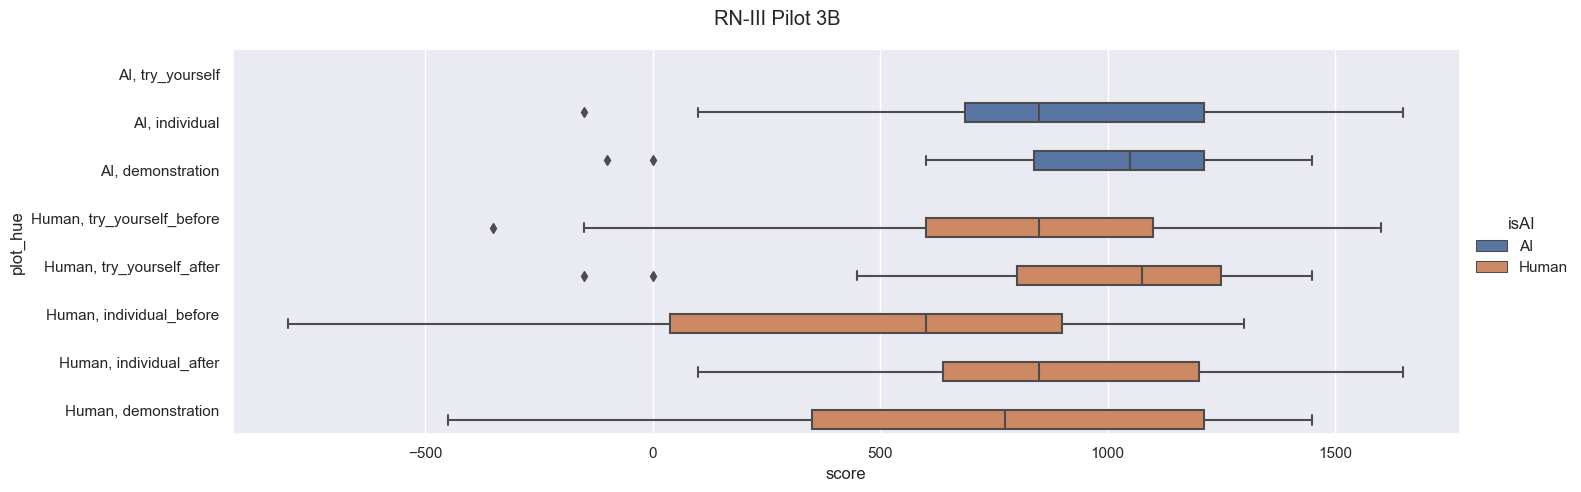

In [139]:
#box, ax = plt.subplots(figsize=(6.5, 6.5))
#sns.boxplot(scores_df, x="plot_hue", y="score", ax=ax, width=6)

fig1 = sns.catplot(data=scores_df, x="score", y="plot_hue", hue='isAI', kind="box", height=5, aspect=3)
fig1.fig.subplots_adjust(top=0.9)
fig1.fig.suptitle('RN-III Pilot 3B')

if to_save_plots:
    fig1.savefig(os.path.join(figures_path, 'Reward_boxplot_trial_type.pdf'), format='pdf', dpi=300)
    fig1.savefig(os.path.join(figures_path, 'Reward_boxplot_trial_type.png'), format='png', dpi=300)

In [140]:
# average score per participant
scores_df.groupby(by=["sessionId",'isAI','trialType'])['score'].mean().to_frame('avg_score_participant').reset_index()

,sessionId,isAI,trialType,avg_score_participant
0,6422d978aff8868105633828,AI,demonstration,1150.0
1,6422d978aff8868105633828,AI,individual,1050.0
2,6422d978aff8868105633828,AI,try_yourself,NaN
3,6422d978aff8868105633829,AI,demonstration,1350.0
4,6422d978aff8868105633829,AI,individual,1250.0
...,...,...,...,...
75,6422d978aff886810563383c,Human,demonstration,675.0
76,6422d978aff886810563383c,Human,individual_after,725.0
77,6422d978aff886810563383c,Human,individual_before,-525.0
78,6422d978aff886810563383c,Human,try_yourself_after,837.5


## Find out which advisors were loss AI, and which were myopic AI

In [9]:
moves = pd.read_csv(os.path.join(f"../../data/final/rn-iii-pilot-3B/moves.csv"),sep=',', index_col=0)
moves

,sessionId,trialID,networkId,sourceLevel,targetLevel,reward,step,isMissing,matchesMyopic,matchesAI
0,6422d978aff8868105633828,0,ee03606912fff2d5496ca438ddf0e182,0,1,-50,1,False,False,True
1,6422d978aff8868105633828,0,ee03606912fff2d5496ca438ddf0e182,1,2,-50,2,False,False,True
2,6422d978aff8868105633828,0,ee03606912fff2d5496ca438ddf0e182,2,3,-50,3,False,False,True
3,6422d978aff8868105633828,0,ee03606912fff2d5496ca438ddf0e182,3,4,200,4,False,False,True
4,6422d978aff8868105633828,0,ee03606912fff2d5496ca438ddf0e182,4,3,400,5,False,False,True
...,...,...,...,...,...,...,...,...,...,...
1755,6422d978aff886810563383c,30,04fc6cbee3837127477c7577f39b61d5,0,0,100,4,False,False,False
1756,6422d978aff886810563383c,30,04fc6cbee3837127477c7577f39b61d5,0,1,-50,5,False,False,False
1757,6422d978aff886810563383c,30,04fc6cbee3837127477c7577f39b61d5,1,2,-50,6,False,False,False
1758,6422d978aff886810563383c,30,04fc6cbee3837127477c7577f39b61d5,2,0,400,7,False,False,False


In [142]:
ai_session_ids = list(scores_df[scores_df['isAI']=='AI']['sessionId'].unique())
moves_ai = moves[moves['sessionId'].isin(ai_session_ids)]
moves_ai

,sessionId,trialID,networkId,sourceLevel,targetLevel,reward,step,isMissing,matchesMyopic,matchesAI
0,6422d978aff8868105633828,0,ee03606912fff2d5496ca438ddf0e182,0,1,-50,1,False,False,True
1,6422d978aff8868105633828,0,ee03606912fff2d5496ca438ddf0e182,1,2,-50,2,False,False,True
2,6422d978aff8868105633828,0,ee03606912fff2d5496ca438ddf0e182,2,3,-50,3,False,False,True
3,6422d978aff8868105633828,0,ee03606912fff2d5496ca438ddf0e182,3,4,200,4,False,False,True
4,6422d978aff8868105633828,0,ee03606912fff2d5496ca438ddf0e182,4,3,400,5,False,False,True
...,...,...,...,...,...,...,...,...,...,...
475,6422d978aff8868105633831,5,e8734b5b66bca9a8369582876f59eafe,0,0,100,4,False,True,False
476,6422d978aff8868105633831,5,e8734b5b66bca9a8369582876f59eafe,0,0,100,5,False,True,False
477,6422d978aff8868105633831,5,e8734b5b66bca9a8369582876f59eafe,0,0,100,6,False,True,False
478,6422d978aff8868105633831,5,e8734b5b66bca9a8369582876f59eafe,0,0,100,7,False,True,False


In [143]:
moves_matches = moves_ai.groupby(by=['sessionId']).agg(n_myopic_matches=('matchesMyopic','sum'),
                                       n_ai_matches=('matchesAI','sum')).reset_index()

loss_ai = list(moves_matches[moves_matches['n_myopic_matches']<=1]['sessionId'])
myopic_ai = list(moves_matches[moves_matches['n_myopic_matches']>1]['sessionId'])

In [144]:
myopic_ai

['6422d978aff886810563382b',
 '6422d978aff886810563382c',
 '6422d978aff886810563382d',
 '6422d978aff886810563382e',
 '6422d978aff886810563382f',
 '6422d978aff8868105633830',
 '6422d978aff8868105633831']

In [145]:
scores_df

,sessionId,isAI,expName,generation,trialIdx,trialType,networkId,score,maxLevelReached,myopic_score,ai_score,plot_hue
0,6422d978aff8868105633828,AI,rn-iii-pilot-3B,0,NaN,try_yourself,NaN,NaN,NaN,NaN,NaN,"AI, try_yourself"
1,6422d978aff8868105633828,AI,rn-iii-pilot-3B,0,0.0,individual,ee03606912fff2d5496ca438ddf0e182,1050.0,4.0,600.0,1050.0,"AI, individual"
2,6422d978aff8868105633828,AI,rn-iii-pilot-3B,0,1.0,individual,b06e63e23be6e795171cc39de5f68b04,1050.0,4.0,1200.0,1050.0,"AI, individual"
3,6422d978aff8868105633828,AI,rn-iii-pilot-3B,0,2.0,individual,cb226a27079683c5a81e7c73450fd1d7,850.0,4.0,800.0,850.0,"AI, individual"
4,6422d978aff8868105633828,AI,rn-iii-pilot-3B,0,3.0,individual,bbd3fb74933edbeb8aee7fb3ead010ec,1250.0,4.0,800.0,1250.0,"AI, individual"
...,...,...,...,...,...,...,...,...,...,...,...,...
225,6422d978aff886810563383c,Human,rn-iii-pilot-3B,1,25.0,individual_after,a2c663a5e2c6b59d546691602456bfce,100.0,2.0,0.0,1250.0,"Human, individual_after"
226,6422d978aff886810563383c,Human,rn-iii-pilot-3B,1,26.0,individual_after,35f070abfb64c2499229d1ee32cf54b6,1050.0,1.0,1100.0,1450.0,"Human, individual_after"
227,6422d978aff886810563383c,Human,rn-iii-pilot-3B,1,27.0,individual_after,8873dfa1b3059e8c7bbb2a75f76b3b83,350.0,1.0,350.0,1250.0,"Human, individual_after"
228,6422d978aff886810563383c,Human,rn-iii-pilot-3B,1,29.0,demonstration,59bc73ae47a896adda8a3eeec20e03fb,1000.0,2.0,650.0,850.0,"Human, demonstration"


In [146]:
trial = pd.read_csv(os.path.join(f"../../data/final/rn-iii-pilot-3B/trial.csv"),sep=',')
trial

,Unnamed: 0,sessionId,generation,trialType,trialIdx,parentSessionId,parentSession_isAI
0,0,6422d978aff8868105633828,0,individual,0,NaN,NaN
1,1,6422d978aff8868105633828,0,individual,1,NaN,NaN
2,2,6422d978aff8868105633828,0,individual,2,NaN,NaN
3,3,6422d978aff8868105633828,0,individual,3,NaN,NaN
4,4,6422d978aff8868105633828,0,demonstration,4,NaN,NaN
...,...,...,...,...,...,...,...
405,405,6422d978aff886810563383c,1,demonstration,29,NaN,NaN
406,406,6422d978aff886810563383c,1,demonstration,30,NaN,NaN
407,407,6422d978aff886810563383c,1,written_strategy,31,NaN,NaN
408,408,6422d978aff886810563383c,1,post_survey,32,NaN,NaN


In [147]:
learned_from_myopic_ai = list(trial[trial['parentSessionId'].isin(myopic_ai)]['sessionId'].unique())
learned_from_loss_ai = list(trial[trial['parentSessionId'].isin(loss_ai)]['sessionId'].unique())

In [148]:
learned_from_myopic_ai

['6422d978aff8868105633833',
 '6422d978aff8868105633834',
 '6422d978aff8868105633837',
 '6422d978aff886810563383b',
 '6422d978aff886810563383c']

In [149]:
learned_from_loss_ai

['6422d978aff8868105633832',
 '6422d978aff8868105633833',
 '6422d978aff8868105633834',
 '6422d978aff8868105633835',
 '6422d978aff8868105633836',
 '6422d978aff8868105633837',
 '6422d978aff8868105633838',
 '6422d978aff886810563383a',
 '6422d978aff886810563383c']

## performance across trial plots

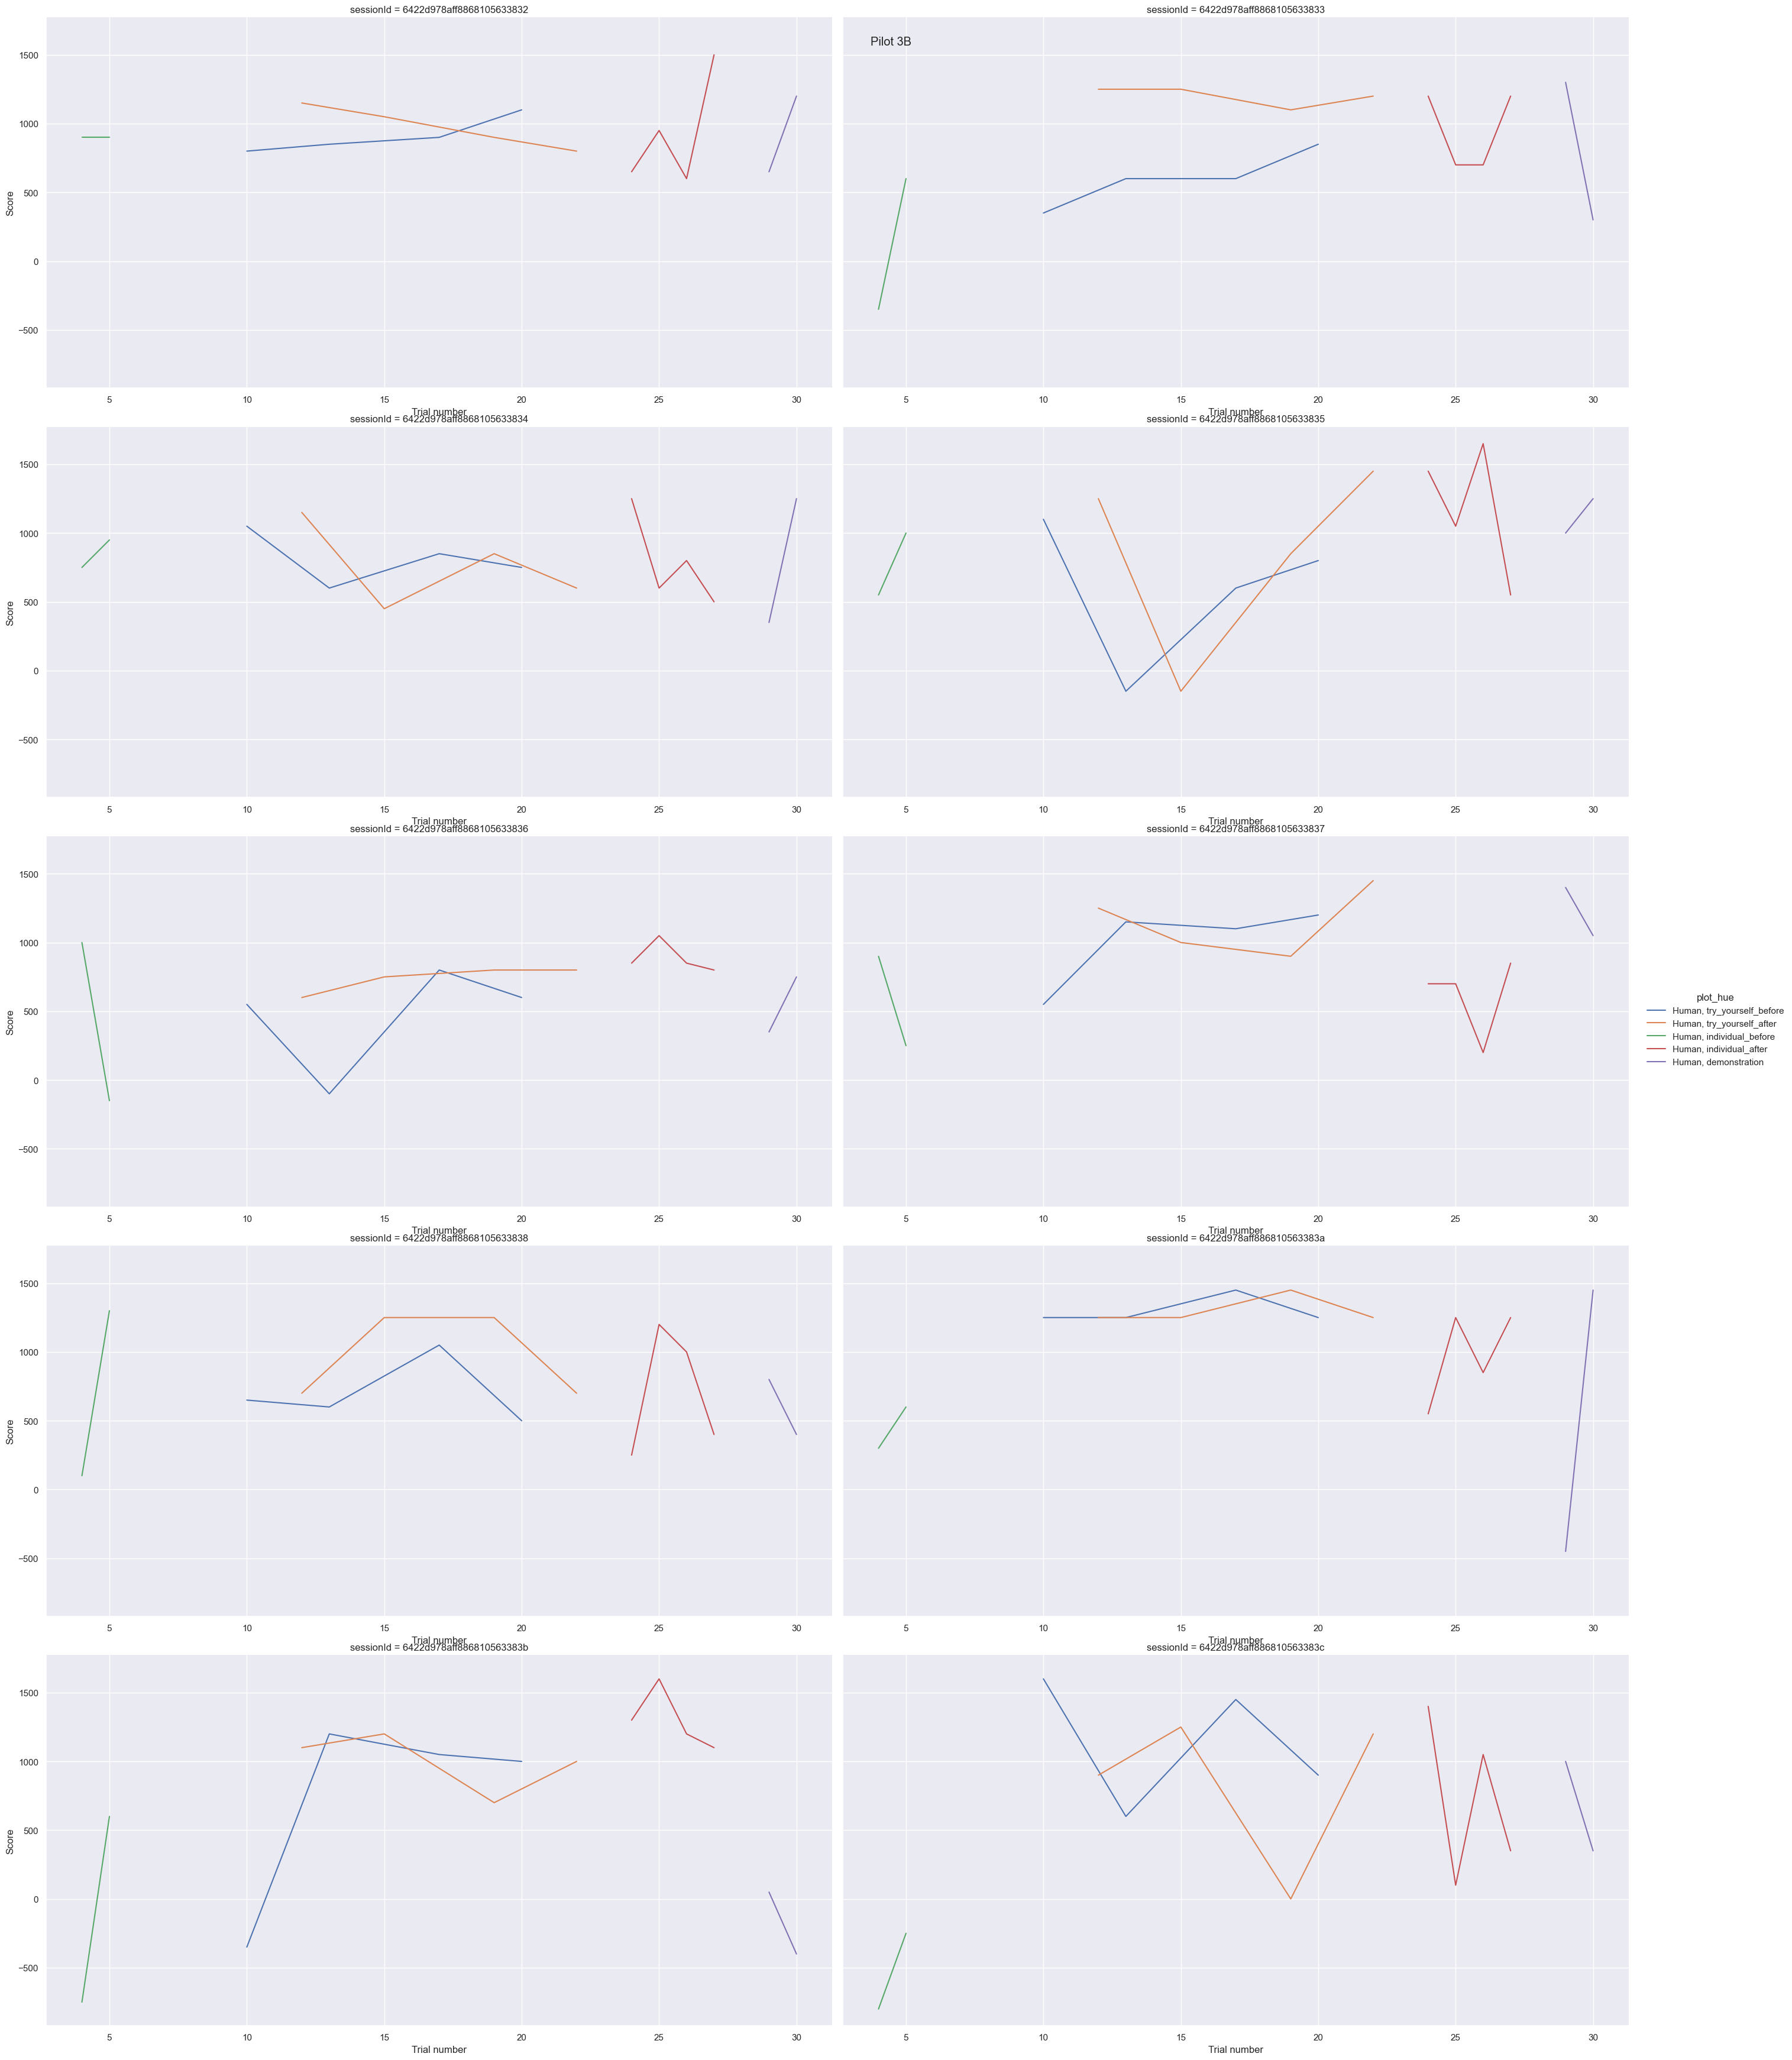

In [150]:
# create plot hue specifically for human - trial type combo
fig = sns.relplot(data=scores_df[scores_df['isAI']=='Human'],
                      x="trialIdx",
                      y="score",
                      hue='plot_hue',
                      col="sessionId",
                      col_wrap=2,
                      kind="line",
                      errorbar='ci',
                      facet_kws=dict(sharey=True,sharex=False),
                      #palette={'individual, Human':'green', 'demonstration, Human':'#6bdb9c'},
                      height=7,
                      aspect=2,
                      legend='full')
fig.set(xlabel="Trial number", ylabel="Score")
fig.fig.suptitle("Pilot 3B")

if to_save_plots:
    fig.savefig(os.path.join(figures_path, 'Score_over_trialIdx_session.pdf'), format='pdf', dpi=300)
    fig.savefig(os.path.join(figures_path, 'Score_over_trialIdx_session.png'), format='png', dpi=300)


## check for number of steps in trials

In [179]:
human_session_ids = list(scores_df[scores_df['isAI']=='Human']['sessionId'].unique())
moves_human = moves[moves['sessionId'].isin(human_session_ids)]
missings = moves_human.groupby(by=['sessionId','trialID']).agg(n_missings=('isMissing','sum')).reset_index()

In [180]:
missings

,sessionId,trialID,n_missings
0,6422d978aff8868105633832,4,0
1,6422d978aff8868105633832,5,0
2,6422d978aff8868105633832,10,0
3,6422d978aff8868105633832,12,0
4,6422d978aff8868105633832,13,0
...,...,...,...
155,6422d978aff886810563383c,25,2
156,6422d978aff886810563383c,26,0
157,6422d978aff886810563383c,27,0
158,6422d978aff886810563383c,29,0


In [181]:
print(f"{len(missings[missings['n_missings']>0])} out of {len(missings)} trials ({len(missings[missings['n_missings']>0]) / len(missings) *100} %) have missing steps")

17 out of 160 trials (10.625 %) have missing steps


In [182]:
missings[missings['n_missings']>0]['n_missings'].value_counts(normalize=True)

1    0.352941
5    0.176471
4    0.176471
3    0.117647
7    0.058824
8    0.058824
2    0.058824
Name: n_missings, dtype: float64

In [183]:
print(f"{len(missings[missings['n_missings']>1])} out of {len(missings)} trials ({len(missings[missings['n_missings']>0]) / len(missings) *100} %) have missing steps")

11 out of 160 trials (10.625 %) have missing steps


In [184]:
true_missings = missings[missings['n_missings']>0]
true_missings['trialType']='demonstration'
true_missings.loc[true_missings['trialID'].isin([4,5]),'trialType'] = 'individual_before'
true_missings.loc[true_missings['trialID'].between(10,22),'trialType'] = 'try_yourself_before'
true_missings.loc[true_missings['trialID'].isin([25]),'trialType'] = 'individual_after'
true_missings['trialType'].value_counts(normalize=True)

/var/folders/bf/1wzkxhv923145cbh3xbz51kh0000gr/T/ipykernel_1949/2302601842.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_missings['trialType']='demonstration'


individual_before      0.470588
try_yourself_before    0.235294
demonstration          0.235294
individual_after       0.058824
Name: trialType, dtype: float64

In [161]:
missings[missings['n_missings']>0]['trialID'].value_counts(normalize=True)

4     0.352941
30    0.117647
13    0.117647
29    0.117647
5     0.117647
17    0.058824
10    0.058824
25    0.058824
Name: trialID, dtype: float64

## level reached plots

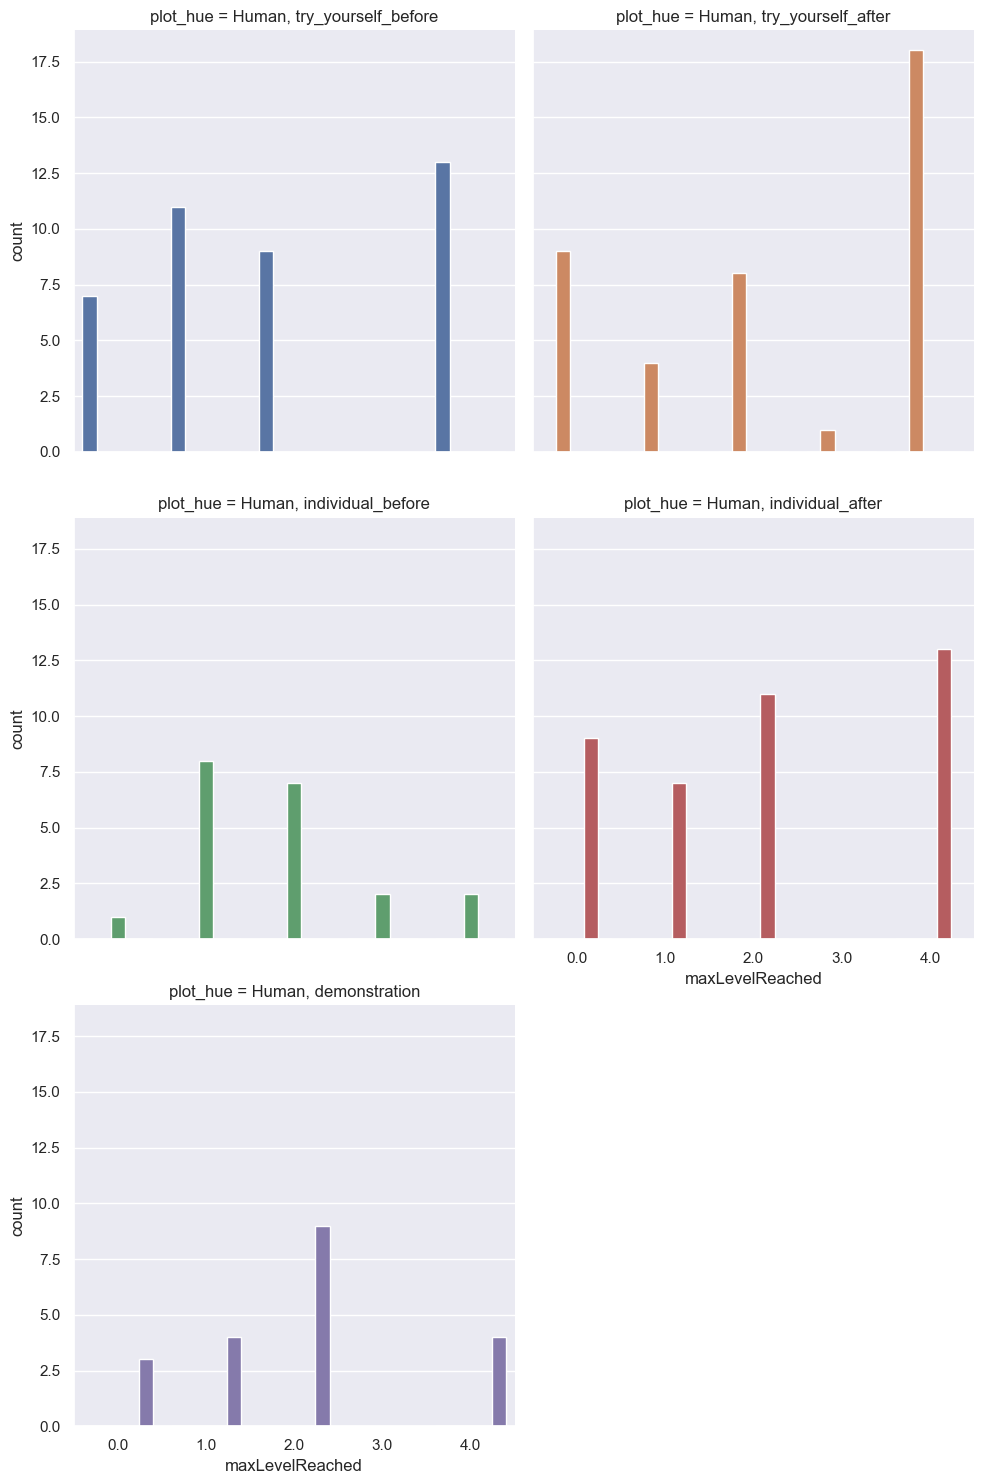

In [153]:
g= sns.catplot(data=scores_df[scores_df['isAI']=='Human'],x="maxLevelReached",
               kind='count',hue='plot_hue',col="plot_hue", col_wrap=2)

if to_save_plots:
    g.savefig(os.path.join(figures_path, 'maxLevel_dist_trial_type.pdf'), format='pdf', dpi=300)
    g.savefig(os.path.join(figures_path, 'maxLevel_dist_trial_type.png'), format='png', dpi=300)

## focus on individual trials

In [154]:
df_individual = scores_df[scores_df['plot_hue'].isin(['Human, individual_before','Human, individual_after'])]
df_try_yourself = scores_df[scores_df['plot_hue'].isin(['Human, try_yourself_before','Human, try_yourself_after'])]
df_individual

,sessionId,isAI,expName,generation,trialIdx,trialType,networkId,score,maxLevelReached,myopic_score,ai_score,plot_hue
78,6422d978aff8868105633832,Human,rn-iii-pilot-3B,1,4.0,individual_before,e9073951acef262498eac37b38155caf,900.0,2.0,1000.0,1150.0,"Human, individual_before"
79,6422d978aff8868105633832,Human,rn-iii-pilot-3B,1,5.0,individual_before,282a6cc7486e263d2b0fee9e3f1972f7,900.0,1.0,400.0,1050.0,"Human, individual_before"
80,6422d978aff8868105633832,Human,rn-iii-pilot-3B,1,24.0,individual_after,d34c336c4eb89dcdbf7822e604104c8d,650.0,1.0,800.0,1450.0,"Human, individual_after"
81,6422d978aff8868105633832,Human,rn-iii-pilot-3B,1,25.0,individual_after,effdef11328d73c3c5fb806e1f13adc1,950.0,4.0,1200.0,1250.0,"Human, individual_after"
82,6422d978aff8868105633832,Human,rn-iii-pilot-3B,1,26.0,individual_after,0f145ca3e4e5228d4e3449f685bb10b8,600.0,1.0,400.0,1250.0,"Human, individual_after"
83,6422d978aff8868105633832,Human,rn-iii-pilot-3B,1,27.0,individual_after,0bddb988344c63b517199423b95804e4,1500.0,0.0,1500.0,1650.0,"Human, individual_after"
94,6422d978aff8868105633833,Human,rn-iii-pilot-3B,1,4.0,individual_before,5d7c38f6314a4ad3ae28ea51f832d6b5,-350.0,1.0,900.0,1250.0,"Human, individual_before"
95,6422d978aff8868105633833,Human,rn-iii-pilot-3B,1,5.0,individual_before,ef6faa2a7b3212e04fdf1a319b796812,600.0,4.0,650.0,1250.0,"Human, individual_before"
96,6422d978aff8868105633833,Human,rn-iii-pilot-3B,1,24.0,individual_after,23eec9f49d5651260877a2b0f926979a,1200.0,0.0,1200.0,1250.0,"Human, individual_after"
97,6422d978aff8868105633833,Human,rn-iii-pilot-3B,1,25.0,individual_after,268b96a55e3092c64316ab7dcb993406,700.0,1.0,600.0,1050.0,"Human, individual_after"


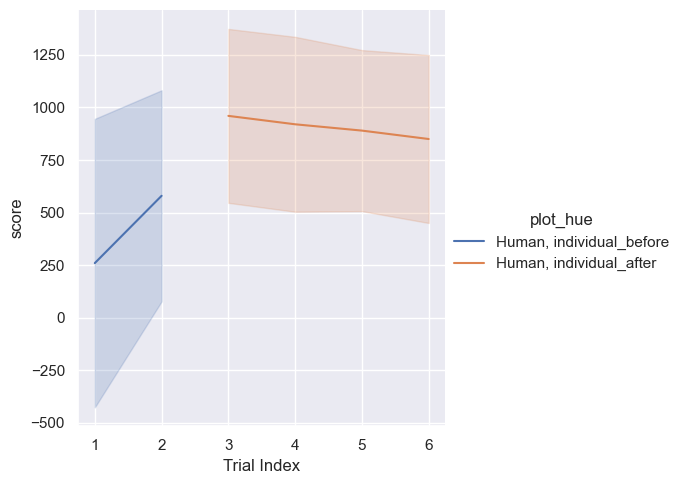

In [155]:
df_individual.loc[df_individual['trialIdx']==4,'trialIdx']=1
df_individual.loc[df_individual['trialIdx']==5,'trialIdx']=2
df_individual.loc[df_individual['trialIdx']==24,'trialIdx']=3
df_individual.loc[df_individual['trialIdx']==25,'trialIdx']=4
df_individual.loc[df_individual['trialIdx']==26,'trialIdx']=5
df_individual.loc[df_individual['trialIdx']==27,'trialIdx']=6

# individual performance over trial idx (score)
prova = sns.relplot(data=df_individual, x="trialIdx", y="score",
                    hue='plot_hue', kind="line", errorbar='sd',
                    facet_kws=dict(sharey=True,sharex=False))
# add label to the axis and label to the plot
prova.set(xlabel="Trial Index", ylabel="score")
if to_save_plots:
    prova.savefig(os.path.join(figures_path, 'Score_individual_trial_type.pdf'), format='pdf', dpi=300)
    prova.savefig(os.path.join(figures_path, 'Score_individual_trial_type.png'), format='png', dpi=300)

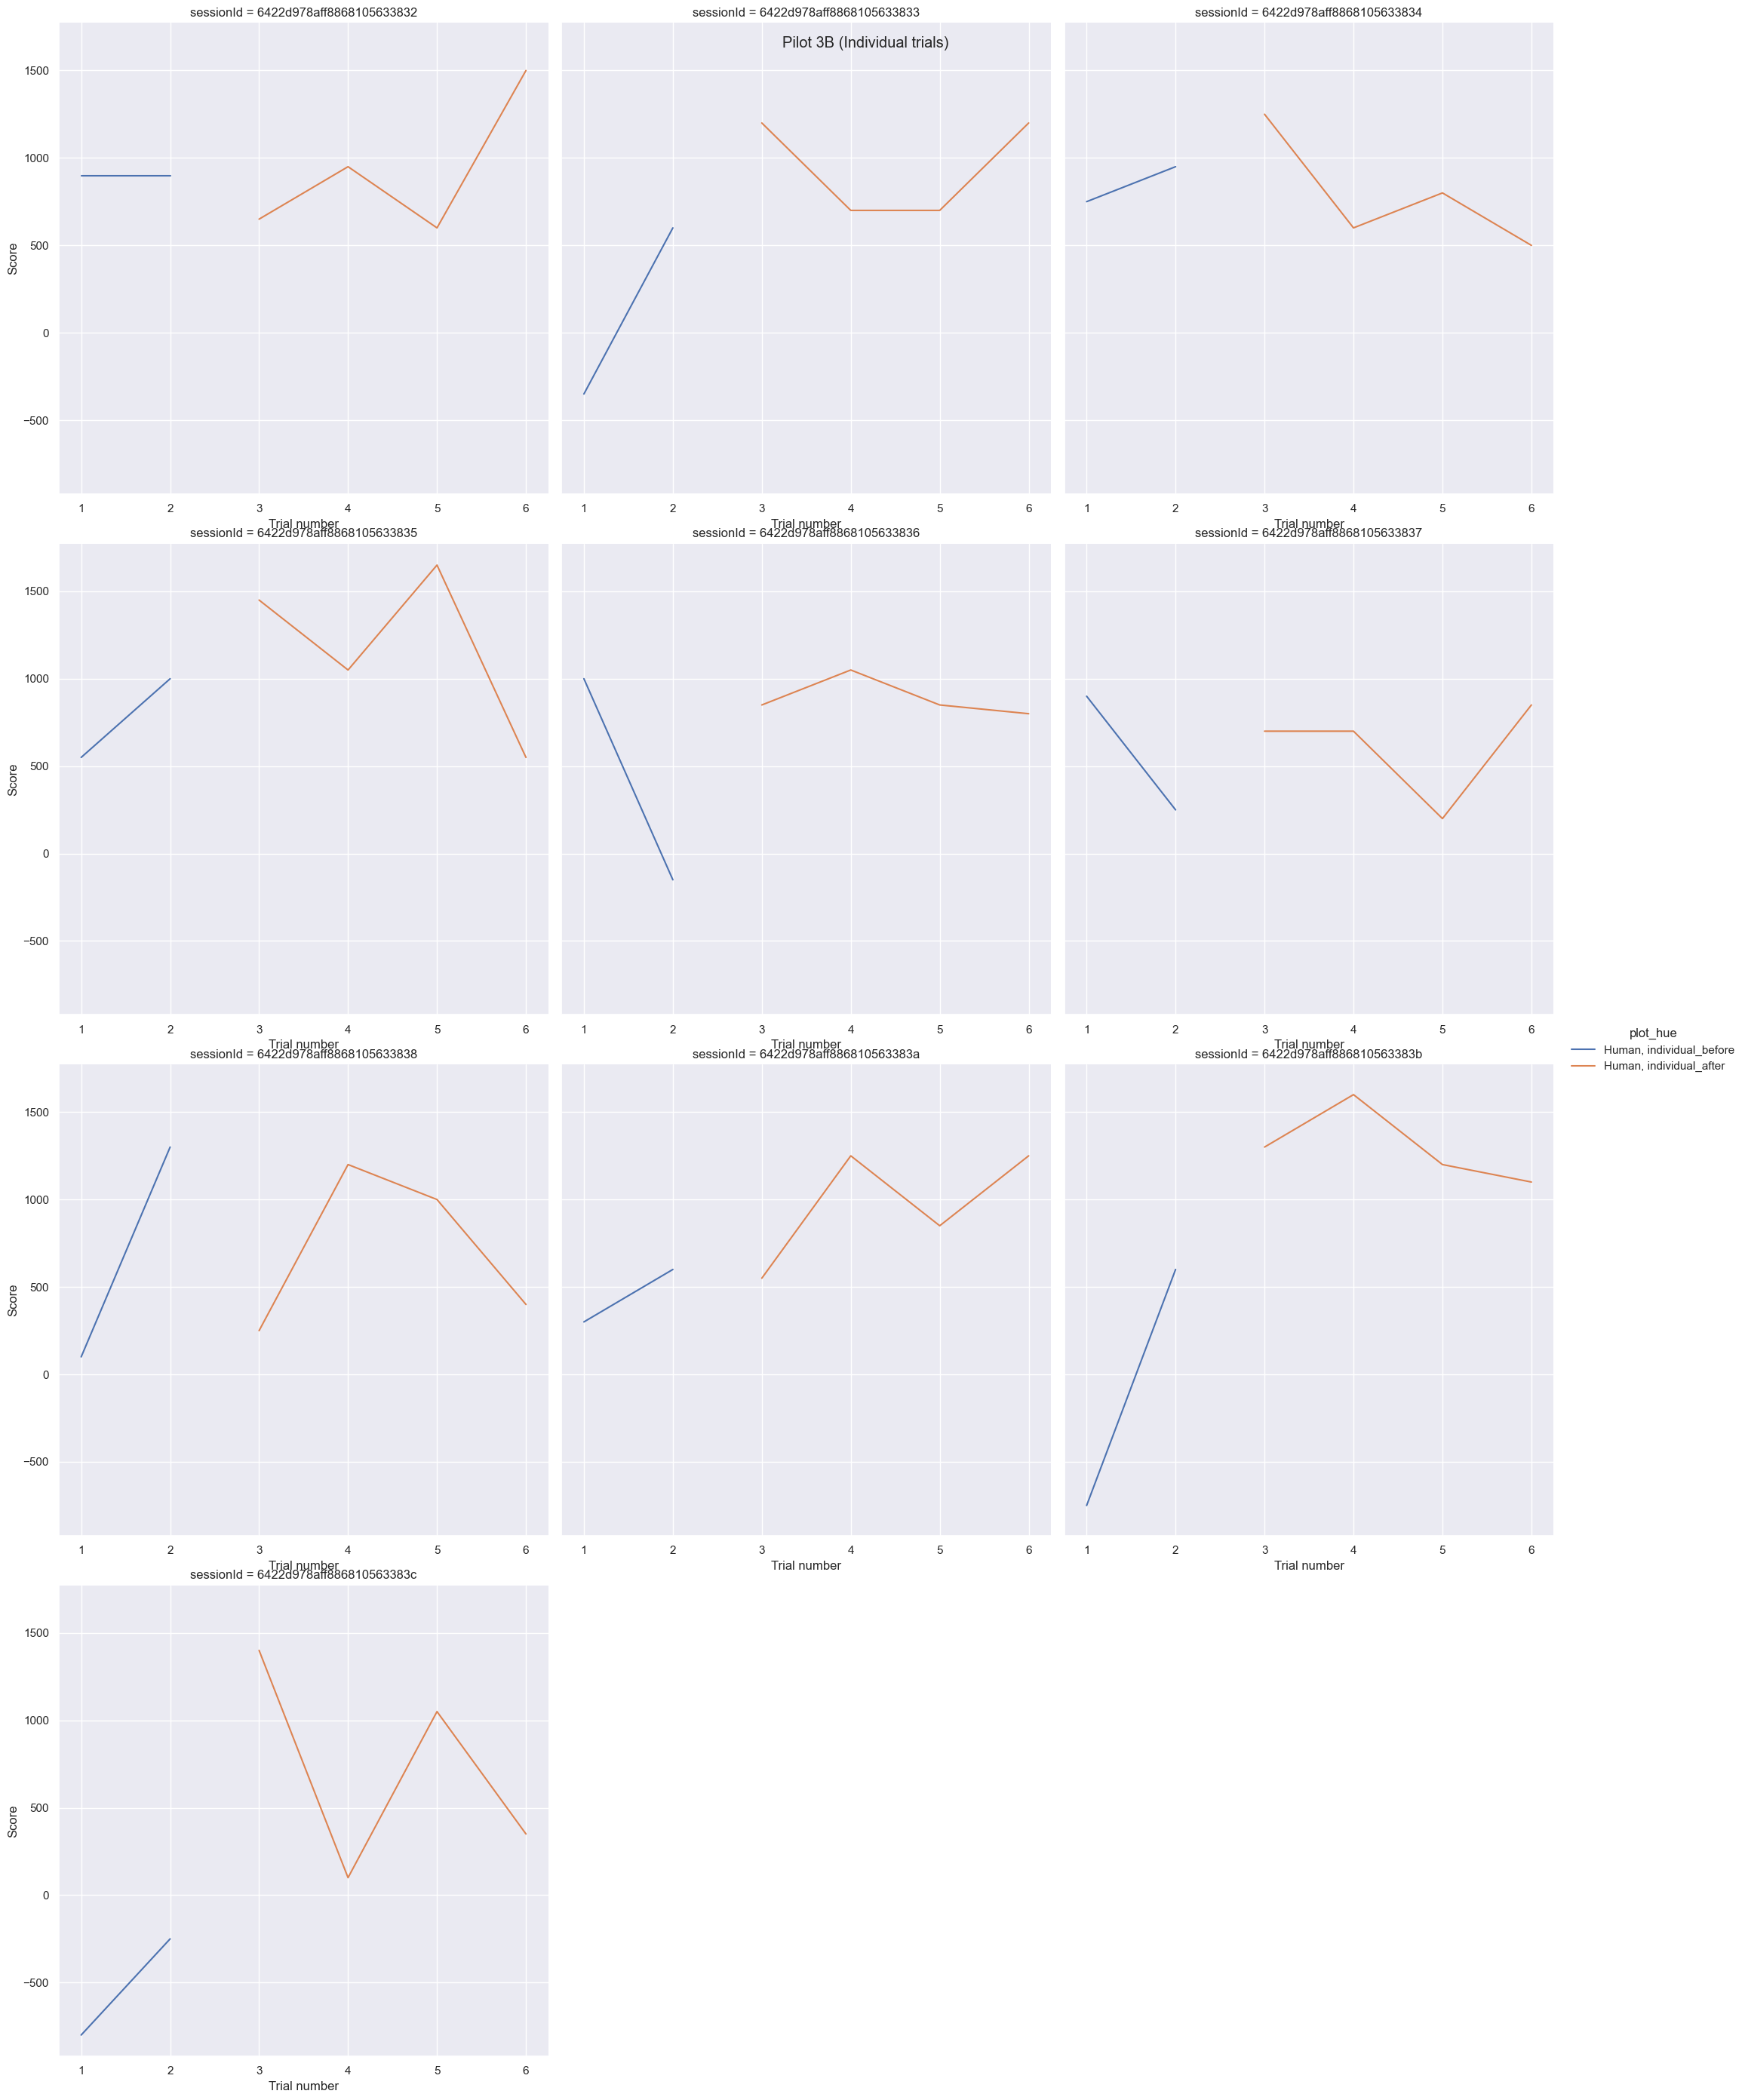

In [156]:
fig = sns.relplot(data=df_individual,
                  x="trialIdx",
                  y="score",
                  hue='plot_hue',
                  col="sessionId",
                  col_wrap=3,
                  kind="line",
                  errorbar='ci',
                  facet_kws=dict(sharey=True,sharex=False),
                  #palette={'individual, Human':'green', 'demonstration, Human':'#6bdb9c'},
                  height=7,
                  legend='full')
fig.set(xlabel="Trial number", ylabel="Score")
fig.fig.suptitle("Pilot 3B (Individual trials)")
if to_save_plots:
    fig.savefig(os.path.join(figures_path, 'Score_individual_trial_type_session.pdf'), format='pdf', dpi=300)
    fig.savefig(os.path.join(figures_path, 'Score_individual_trial_type_session.png'), format='png', dpi=300)

In [157]:
df_try_yourself

,sessionId,isAI,expName,generation,trialIdx,trialType,networkId,score,maxLevelReached,myopic_score,ai_score,plot_hue
70,6422d978aff8868105633832,Human,rn-iii-pilot-3B,1,10.0,try_yourself_before,51edc36de506ff346ed262c1081554eb,800.0,0.0,800.0,1450.0,"Human, try_yourself_before"
71,6422d978aff8868105633832,Human,rn-iii-pilot-3B,1,12.0,try_yourself_after,51edc36de506ff346ed262c1081554eb,1150.0,4.0,800.0,1450.0,"Human, try_yourself_after"
72,6422d978aff8868105633832,Human,rn-iii-pilot-3B,1,13.0,try_yourself_before,31d35353bbfefdb5c7596273e9615d25,850.0,1.0,1000.0,1250.0,"Human, try_yourself_before"
73,6422d978aff8868105633832,Human,rn-iii-pilot-3B,1,15.0,try_yourself_after,31d35353bbfefdb5c7596273e9615d25,1050.0,1.0,1000.0,1250.0,"Human, try_yourself_after"
74,6422d978aff8868105633832,Human,rn-iii-pilot-3B,1,17.0,try_yourself_before,6432e2a0cd8bcd98e8be048855473b47,900.0,2.0,600.0,850.0,"Human, try_yourself_before"
...,...,...,...,...,...,...,...,...,...,...,...,...
217,6422d978aff886810563383c,Human,rn-iii-pilot-3B,1,15.0,try_yourself_after,ffac4c7b6e9a1d6afaa0d18b45bd17a4,1250.0,4.0,550.0,1250.0,"Human, try_yourself_after"
218,6422d978aff886810563383c,Human,rn-iii-pilot-3B,1,17.0,try_yourself_before,e3108a52b2badae980afc815b7277eb8,1450.0,4.0,0.0,1450.0,"Human, try_yourself_before"
219,6422d978aff886810563383c,Human,rn-iii-pilot-3B,1,19.0,try_yourself_after,e3108a52b2badae980afc815b7277eb8,0.0,0.0,0.0,1450.0,"Human, try_yourself_after"
220,6422d978aff886810563383c,Human,rn-iii-pilot-3B,1,20.0,try_yourself_before,dfae8f381c69dc91a7c5beea75e45a89,900.0,2.0,1200.0,1050.0,"Human, try_yourself_before"


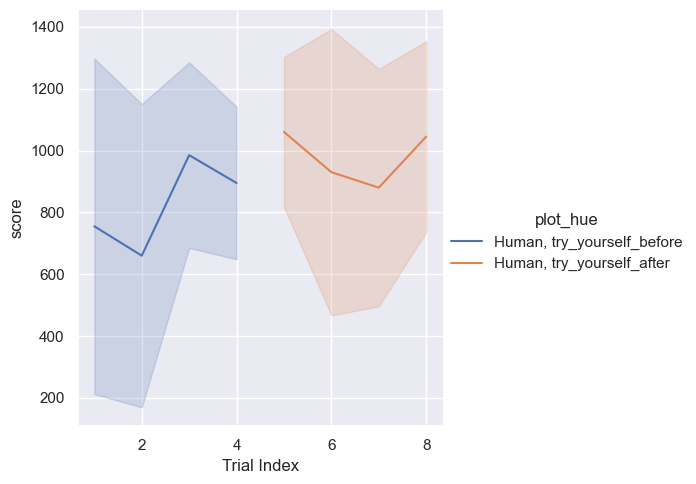

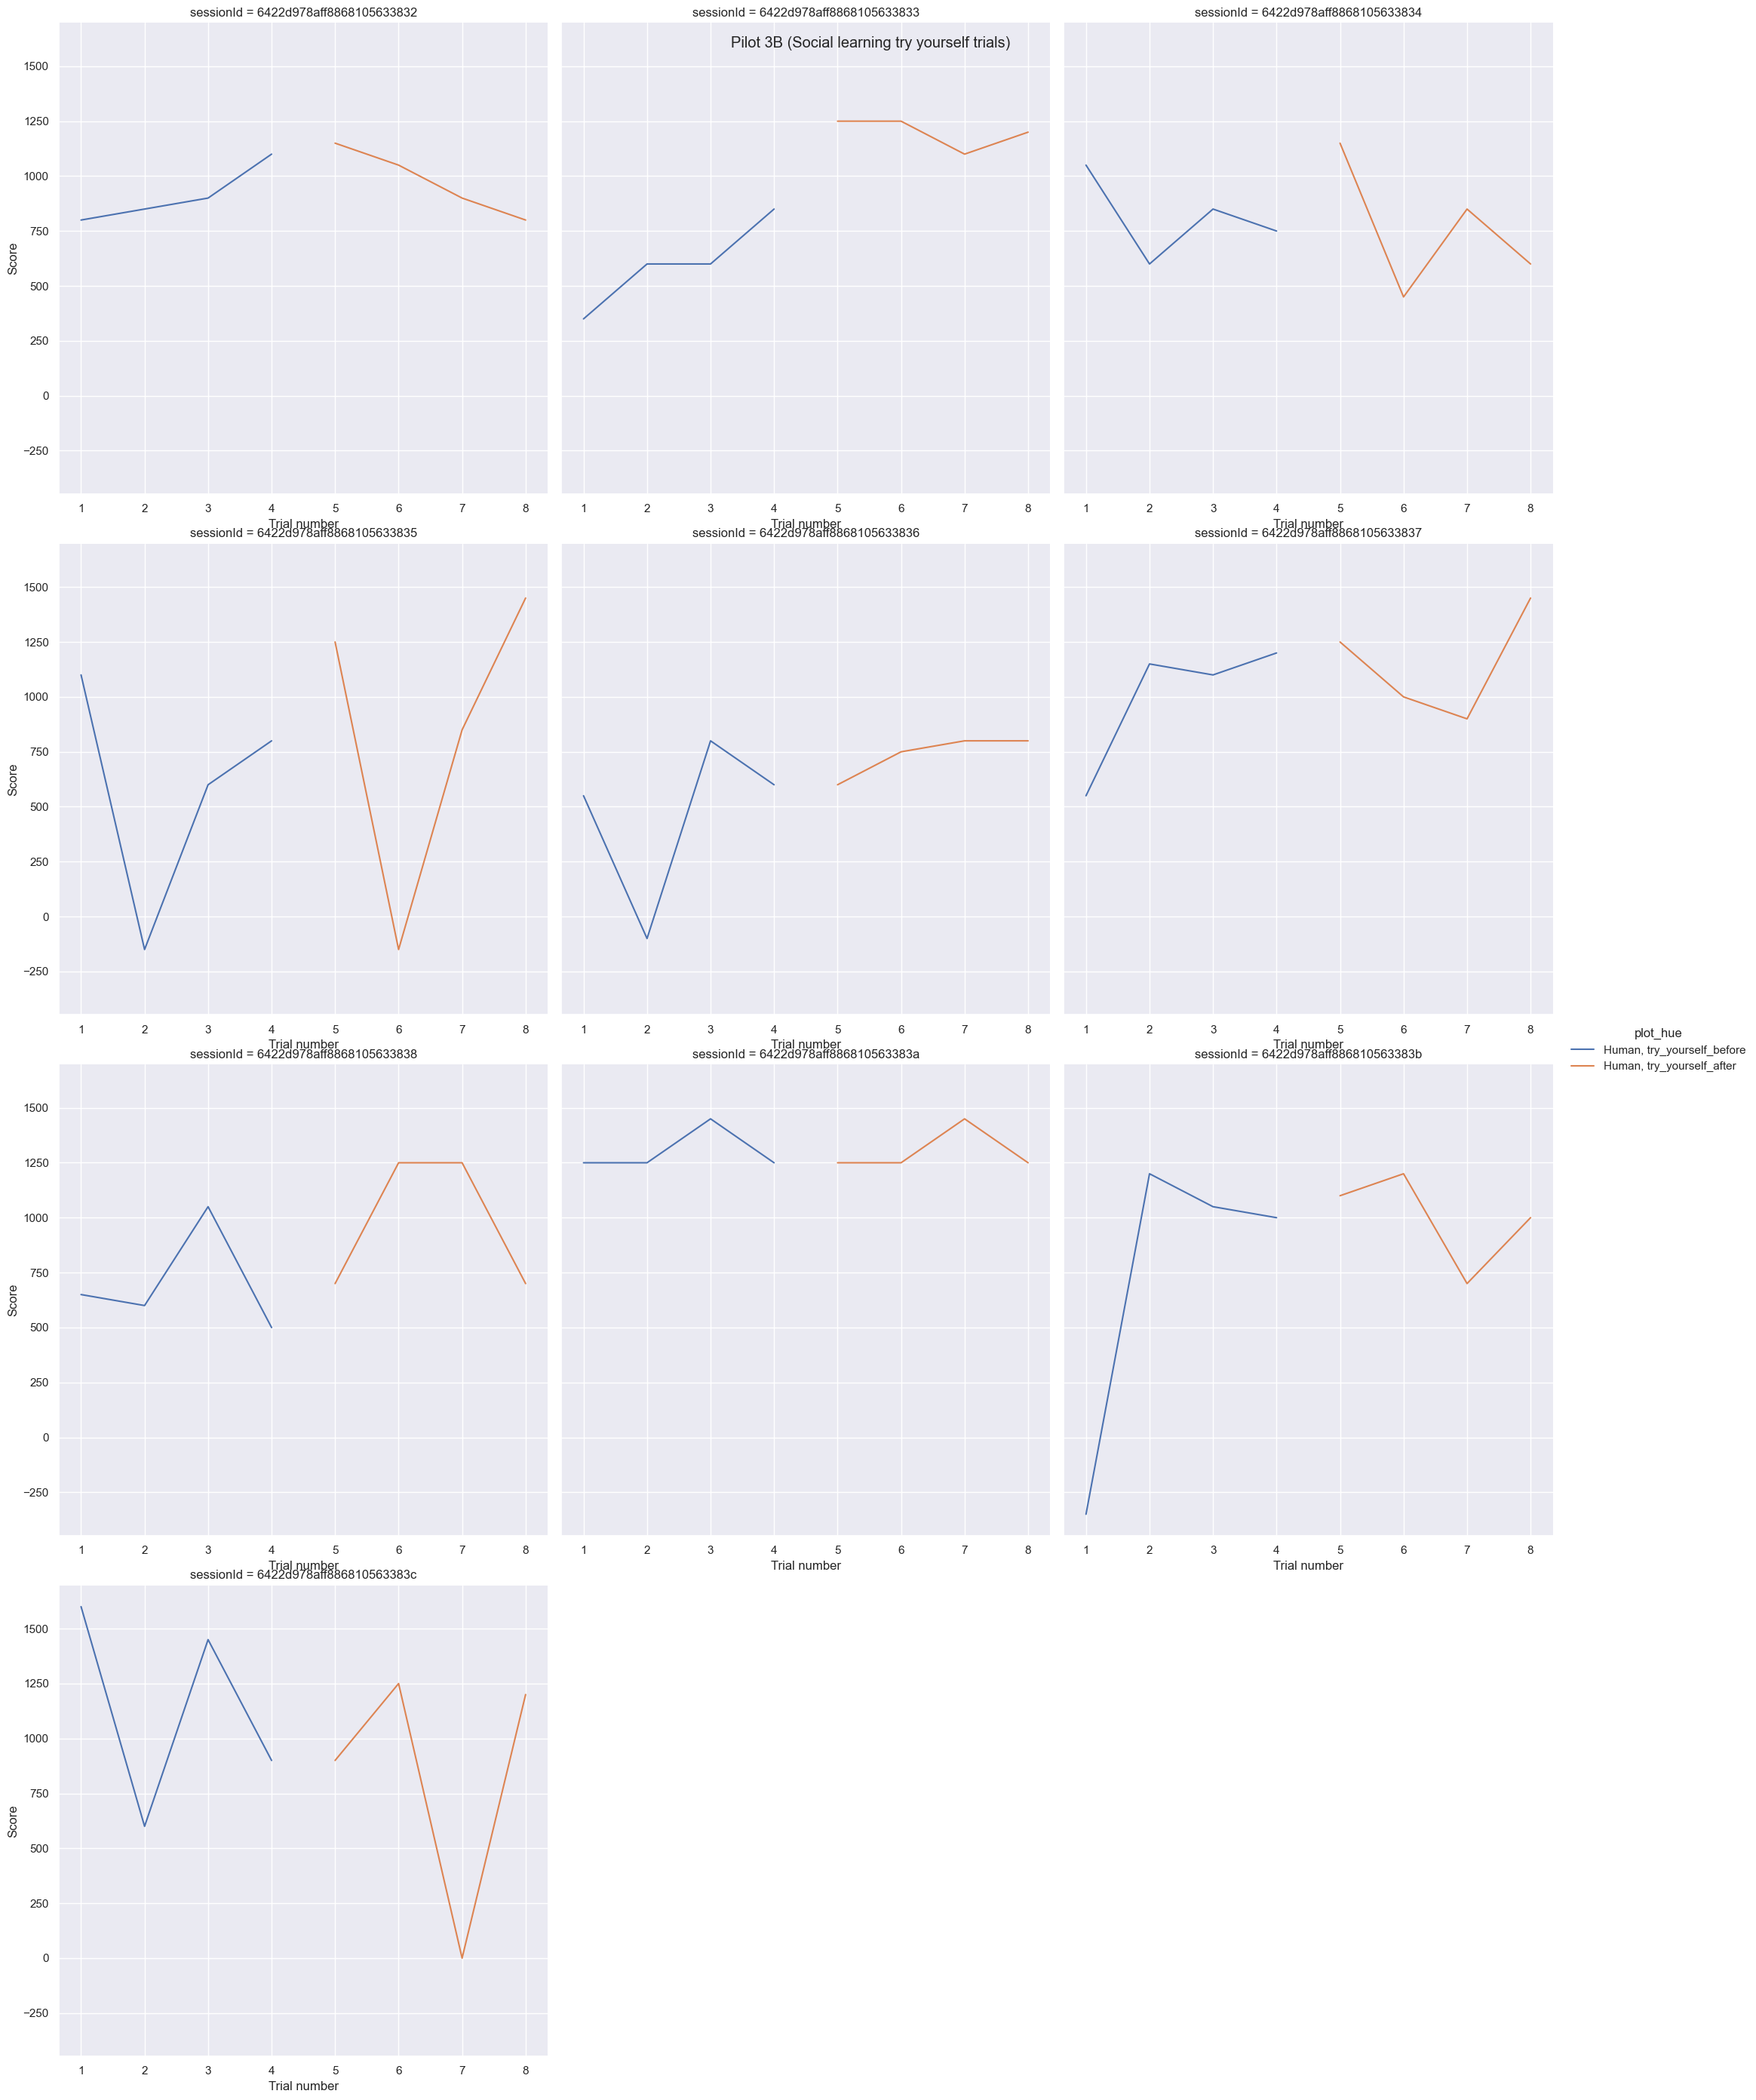

In [158]:
df_try_yourself.loc[df_try_yourself['trialIdx']==10,'trialIdx']=1
df_try_yourself.loc[df_try_yourself['trialIdx']==13,'trialIdx']=2
df_try_yourself.loc[df_try_yourself['trialIdx']==17,'trialIdx']=3
df_try_yourself.loc[df_try_yourself['trialIdx']==20,'trialIdx']=4
df_try_yourself.loc[df_try_yourself['trialIdx']==12,'trialIdx']=5
df_try_yourself.loc[df_try_yourself['trialIdx']==15,'trialIdx']=6
df_try_yourself.loc[df_try_yourself['trialIdx']==19,'trialIdx']=7
df_try_yourself.loc[df_try_yourself['trialIdx']==22,'trialIdx']=8


# individual performance over trial idx (score)
prova = sns.relplot(data=df_try_yourself, x="trialIdx", y="score",
                    hue='plot_hue', kind="line", errorbar='sd',
                    facet_kws=dict(sharey=True,sharex=False))
# add label to the axis and label to the plot
prova.set(xlabel="Trial Index", ylabel="score")
if to_save_plots:
    prova.savefig(os.path.join(figures_path, 'Score_try_yourself_trial_type.pdf'), format='pdf', dpi=300)
    prova.savefig(os.path.join(figures_path, 'Score_try_yourself_trial_type.png'), format='png', dpi=300)


fig = sns.relplot(data=df_try_yourself,
                  x="trialIdx",
                  y="score",
                  hue='plot_hue',
                  col="sessionId",
                  col_wrap=3,
                  kind="line",
                  errorbar='ci',
                  facet_kws=dict(sharey=True,sharex=False),
                  #palette={'individual, Human':'green', 'demonstration, Human':'#6bdb9c'},
                  height=7,
                  legend='full')
fig.set(xlabel="Trial number", ylabel="Score")
fig.fig.suptitle("Pilot 3B (Social learning try yourself trials)")
if to_save_plots:
    fig.savefig(os.path.join(figures_path, 'Score_try_yourself_trial_type_session.pdf'), format='pdf', dpi=300)
    fig.savefig(os.path.join(figures_path, 'Score_try_yourself_trial_type_session.png'), format='png', dpi=300)

## Explore individual trials

In [3]:
scores_df = pd.read_csv(os.path.join(data_path,"scores.csv"),index_col=0)
moves = pd.read_csv(os.path.join(f"../../data/final/rn-iii-pilot-3B/moves.csv"),sep=',', index_col=0)

In [35]:
df = scores_df[scores_df['trialType'].isin(['individual', 'try_yourself', 'demonstration']) & scores_df['isAI'] == False].reset_index(drop=True)

# add columns move_1 to move_8
for i in range(1,9):
    df[f'move_{i}'] = np.nan

# add moves from the moves dataframe to df based on the session id and trial index
for i in range(1,9):
    for idx, row in df.iterrows():
        df.loc[idx, f'move_{i}'] = moves[
            (moves['sessionId'] == row['sessionId']) &
            (moves['trialID'] == row['trialIdx']) &
            (moves['step'] == i)
        ]['reward'].values[0]

df.head(10)

# add short session id with the last 3 characters
df['id'] = df['sessionId'].str[-3:]

# check that id is unique
assert len(df['id'].unique()) == len(df['sessionId'].unique())

# reorganize columns
df = df[['id', 'trialIdx', 'trialType', 'score', 'maxLevelReached', 'move_1', 'move_2', 'move_3', 'move_4', 'move_5', 'move_6', 'move_7', 'move_8', 'networkId', 'myopic_score', 'ai_score', 'sessionId']]

# sort by session id and trial index
df = df.sort_values(by=['sessionId', 'trialIdx']).reset_index(drop=True)

In [36]:
df.to_csv(f"../../data/final/rn-iii-pilot-3B/scores_&_moves.csv", index=False)